In [100]:
import autograd.numpy as np
import numpy
from autograd import jacobian
import scipy.optimize as sciopt
from scipy import interpolate
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

![diagram](figs/diagram.png)

### Install prerequisites

In [ ]:
!pip install autograd
!pip install tqdm

In [120]:
# Lengths of the links
d = [1., 1., 1., 1., 2]

def kinematic_chain(θ, d=d):
    ''' Should equal 0 at solution 
    '''
    θ1, θ2, θ3, θ4 = θ
    d1, d2, d3, d4, _ = d
    return -d1*np.exp(θ1*1j) + d2*np.exp(θ2*1j) + d3*np.exp(θ3*1j) - d4*np.exp(θ4*1j) 

def kinematic_endpoint(θ, d=d):
    ''' Computes the location of the end of the arm 
    '''
    _, θ2, θ3, _ = θ
    _, d2, d3, _, d5 = d
    r = d2*np.exp(θ2*1j) + d5*np.exp(θ3*1j)
    return np.array([np.imag(r), -np.real(r)])

def make_f(θ1, θ2):
    ''' Returns function to pass to optimize.root 
    '''
    def f(θ):
        θ3, θ4 = θ
        r = kinematic_chain([θ1, θ2, θ3, θ4])
        return np.array([np.real(r), np.imag(r)])
    
    return f

def solve_chain(θ1, θ2, x0=np.array([0.,0.])):
    ''' Solves for θ3, θ4 given θ1, θ2 
        TODO: check feasibility. Solution is not unique 
    '''
    _f = make_f(θ1, θ2)
    _jac = jacobian(_f)
    sol = sciopt.root(_f, x0, jac=_jac)
    
    return sol.x


def tests():
    _θ1, _θ2 = np.pi/8, -np.pi/8
    _θ3, _θ4 = solve_chain(_θ1, _θ2)
    
    _θ = np.array([_θ1, _θ2, _θ3, _θ4])
    kinematic_endpoint(_θ)
    
tests()

In [128]:
def compute_mapping(c = np.pi/2, res = np.pi/50):
    ''' Computes mapping from (θ1, θ2) to (x,y) 
    '''
    θ1s, θ2s = numpy.mgrid[-c:c:res, -c:c:res]
    θ1s, θ2s = θ1s.ravel(), θ2s.ravel()
    num = len(θ1s)

    endpoint = []
    θ3,θ4 = 0.,0.
    for θ1, θ2 in tqdm_notebook(zip(θ1s, θ2s)):
        θ3, θ4 = solve_chain(θ1, θ2, x0=np.array([0., 0.]))
        xy = kinematic_endpoint([θ1, θ2, θ3, θ4])
        endpoint.append(xy)

    _input = np.vstack([θ1s,θ2s]).T
    _output = np.array(endpoint).reshape((num, 2))
    return _input, _output    

theta, xy = compute_mapping()

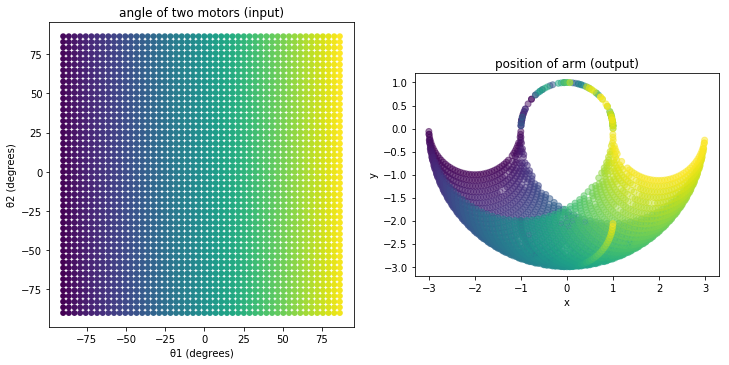

In [178]:
plt.figure(figsize=(12,23))
plt.subplot(1,2,1)
plt.scatter(*theta.T*180/np.pi, c=np.linspace(0,1,len(theta)), linewidth=0)
plt.xlabel('θ1 (degrees)')
plt.ylabel('θ2 (degrees)')
plt.gca().set_aspect('equal')
plt.title('angle of two motors (input)')


plt.subplot(1,2,2)
plt.scatter(*xy.T,c=np.linspace(0,1,len(theta)), alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.title('position of arm (output)')
plt.show()

In [ ]:
x_interp = interpolate.interp2d(theta[:,0], theta[:,1], xy[:,0])
y_interp = interpolate.interp2d(theta[:,0], theta[:,1], xy[:,1])

θ1_interp = interpolate.interp2d(xy[:,0], xy[:,1], theta[:,0])
θ2_interp = interpolate.interp2d(xy[:,0], xy[:,1], theta[:,1])